### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [23]:
%pip install pycbc #pycbc is a specialized physics package needed to perform gravitational wave analysis

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%matplotlib inline #to display plots inline
from pycbc.catalog import Merger #for accessing the data
import pycbc.psd #for power spectral density calculations
from pycbc.psd import analytical #for power spectral density calculations
import pylab #for plotting
import matplotlib.pyplot as plt #for plotting
import numpy as np #for numerical calculations
import pandas as pd #to read in datafiles

In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [26]:
m = Merger('GW150914') #accesses publicly available data from Ligo (first detection)
ifo = 'L1' #loads data from interferometer Livingston (L1)
data = m.strain(ifo) #retrieves strain time series

**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them.

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

In [3]:
print(f"Duration = {data.duration}")
print(f"Sampling Rate = {data.sample_rate}")
print(f"There are {data.duration*data.sample_rate} data points")
print(f"\u0394t is {data.delta_t}")
print(f"\u0394f is {data.delta_f}")
#As deltaf is 1/duration and deltat is 1/sample rate, we can calculate the data points again by:
N = 1/(data.delta_f * data.delta_t)
print(f"When we perform the calculation 1/(\u0394t*\u0394f) we find the number of data points: {N}")

Duration = 32.0
Sampling Rate = 4096.0
There are 131072.0 data points
Δt is 0.000244140625
Δf is 0.03125
When we perform the calculation 1/(Δt*Δf) we find the number of data points: 131072.0


The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

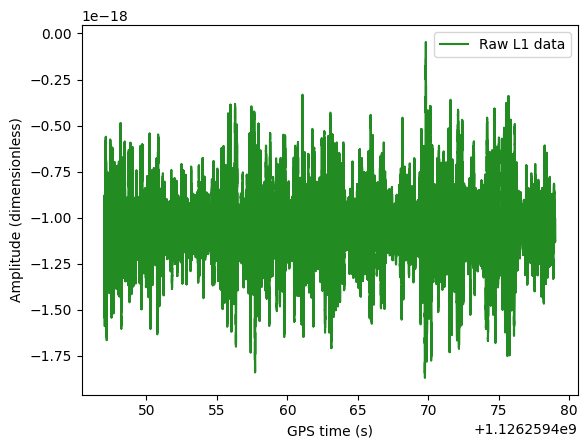

In [27]:
#plot time vs amplitude of the raw L1 data
plt.plot(data.sample_times, data, label='Raw L1 data', color='forestgreen')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton.

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design.

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency.

_Hint_: Note that the PSD is a frequency series.

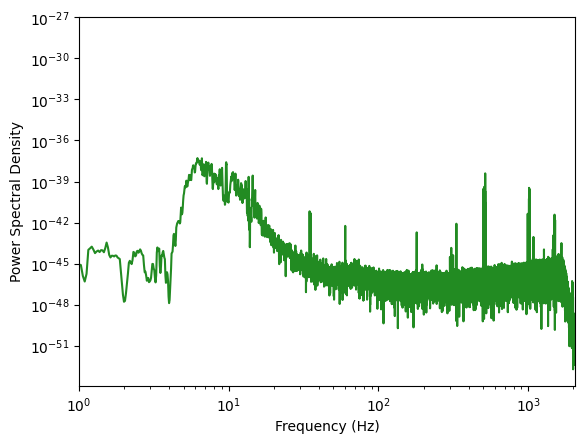

In [28]:
psd = data.filter_psd(data.duration, data.delta_f, flow=1) #estimates the Power Spectral Density (PSD) of the input strain data
#plot psd vs frequency of the raw L1 data on a logarithmic scale
plt.plot(psd.sample_frequencies, psd, label ="Raw L1 data", color = "forestgreen")
plt.xlim(1, psd.sample_rate/2) #limits the plot between 1 Hz and the Nyquist frequency sample_rate/2
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.yscale("log")
plt.xscale("log")

The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`.

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


(1, 2048.0)

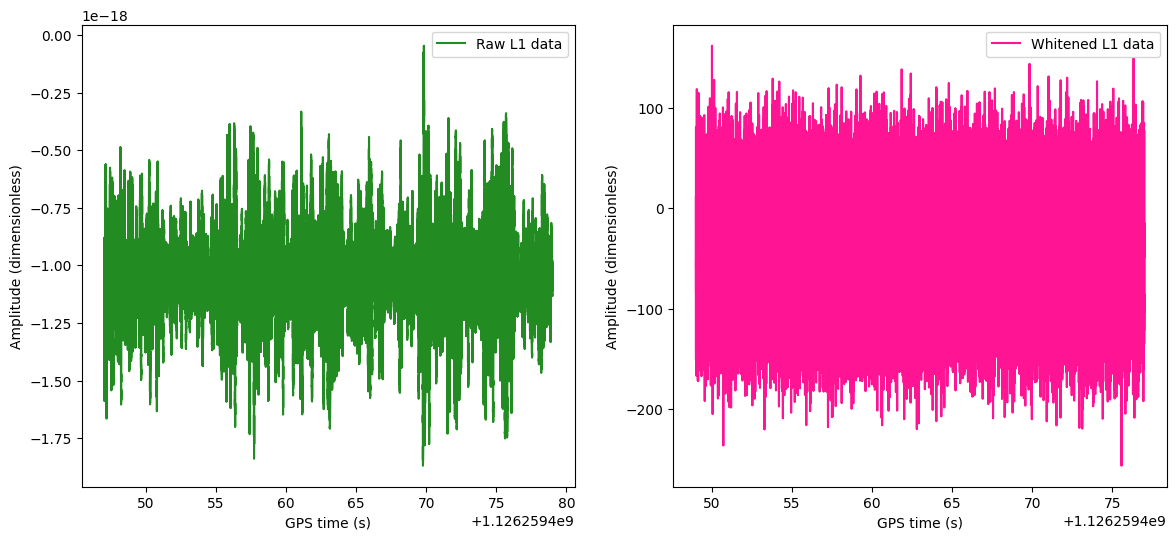

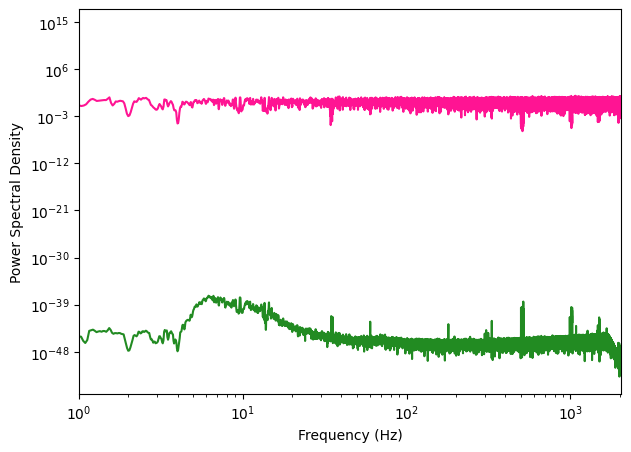

In [29]:
whitened_data = data.whiten(segment_duration = 4, max_filter_duration = 4) #whitens the raw data (flattens frequency dependent noise to provide better visualization of the wave data)
whitened_psd = whitened_data.filter_psd(whitened_data.duration, whitened_data.delta_f, flow=1) #estimates the psd of the whitened data

#plots time vs. amplitude of raw L1 data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(data.sample_times, data, label='Raw L1 data', color='forestgreen')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

#plots time vs. amplitude of whitened L1 data
plt.subplot(1, 2, 2)
plt.plot(whitened_data.sample_times, whitened_data, label='Whitened L1 data', color='deeppink')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

#plots psd vs. sample frequency of both raw and whitened data in the same plot on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.loglog(psd.sample_frequencies, psd, label="Raw L1 Data", color="forestgreen")
plt.loglog(whitened_psd.sample_frequencies, whitened_psd, label="Whitened L1 Data", color="deeppink")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.xlim(1, whitened_data.sample_rate/2) #limits the plot between 1 Hz and the Nyquist frequency sample_rate/2



The whitened data is significantly more 'flat' in both the PSD and amplitude plots, it is not as overpowered by noise, and actual trends might be easier to see. 

Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data.


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

2.5


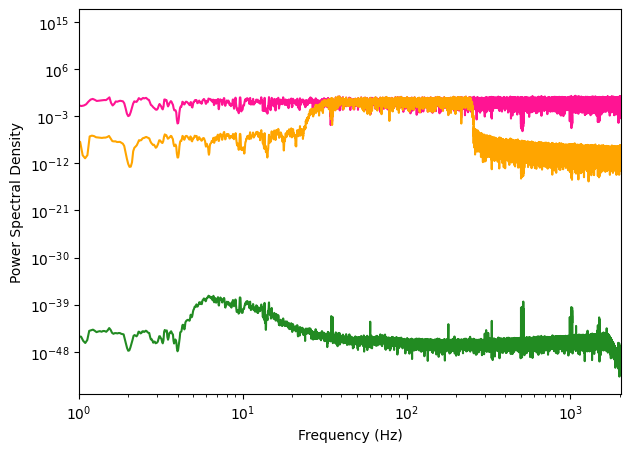

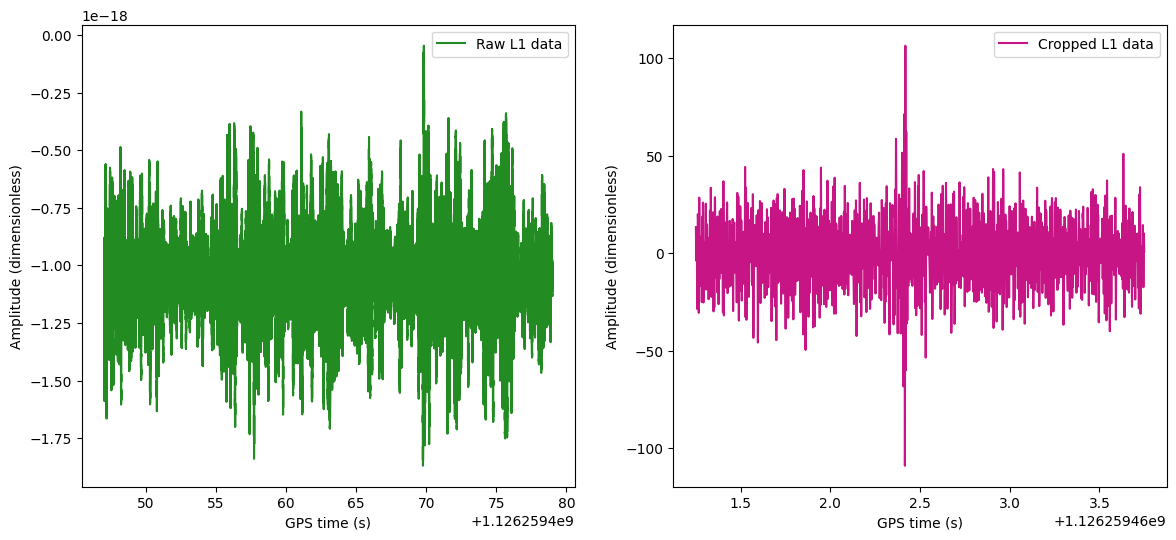

In [30]:
lowpass_white = whitened_data.lowpass_fir(250, 512) #performs a lowpass filter on the whitened data, limiting its frequency
bandpass_white = lowpass_white.highpass_fir(30,512) #performs a highpass filter on the lowpassed whitened data, limiting its frequency

bandpass_white_psd = bandpass_white.filter_psd(bandpass_white.duration, bandpass_white.delta_f, flow=1) #estimates the psd of the bandpassed whitened data

#plots psd vs. sample frequency of raw, whitened and bandpassed data in the same plot on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.loglog(psd.sample_frequencies, psd, label="Raw L1 Data", color="forestgreen")
plt.loglog(whitened_psd.sample_frequencies, whitened_psd, label="Whitened L1 Data", color="deeppink")
plt.loglog(bandpass_white_psd.sample_frequencies, bandpass_white_psd, label="Bandpassed L1 Data", color="orange")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.xlim(1, whitened_data.sample_rate/2) #limits the plot between 1 Hz and the Nyquist frequency sample_rate/2

cropped_bandpass_white = bandpass_white.crop(12, 13) #crops the data 12 seconds from the left and 13 seconds from the right
print(cropped_bandpass_white.duration) #prints the new duration of the timeseries

#plots time vs. amplitude of raw L1 data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(data.sample_times, data, label='Raw L1 data', color='forestgreen')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

#plots time vs. amplitude of cropped, bandpassed and whitened L1 data
plt.subplot(1,2,2)
plt.plot(cropped_bandpass_white.sample_times, cropped_bandpass_white, label='Cropped L1 data', color='mediumvioletred')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()


The bandpass filter filters out both high and low frequencies, as they tend to be very noisy, keeping the frequencies that are likely to be most relevant at their original values. This is very clearly visible in the orange graph on the plot shown above. For the bandpassed data, 30-200 Hz dominates, while in the raw data, the highest peaks are at frequencies lower than 10 Hz. When cropping the data, the time peak corresponding to the gravitational wave data is very clear, while in the original raw data plot, all other noise peaks hide the useful data. 

**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

Text(0, 0.5, 'Frequency (Hz)')

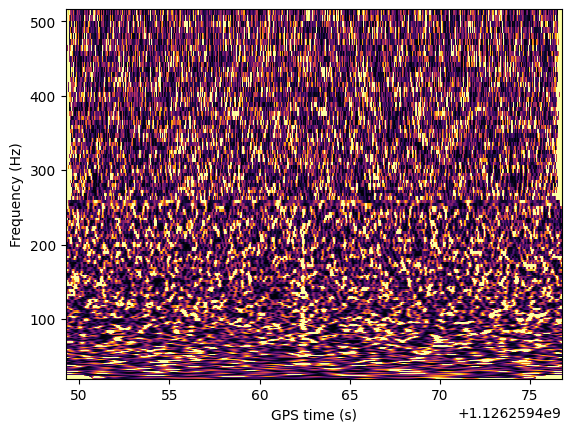

In [9]:
time, freqs, qplane = bandpass_white.qtransform(delta_t= bandpass_white.delta_t, logfsteps=200, frange=(20,512), qrange=(110,110)) #creates a time-frequency spectrogram

plt.pcolormesh(time, freqs, qplane, vmax = 3.5, cmap= "inferno") #creates a '3d' plot in which time and frequency are x and y axes and the power (qplane) is expressed through color
plt.xlabel("GPS time (s)")
plt.ylabel("Frequency (Hz)")



As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


/var/folders/yt/h1dq9sz93x91nnzf7tr_jnmh0000gn/T/ipykernel_4417/3679923157.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  aligoH1 = pd.read_csv('Sensitivity Curve Data/aligo_O3actual_H1.txt', delim_whitespace=True, header=None, names=["Frequency", "PSD"])
/var/folders/yt/h1dq9sz93x91nnzf7tr_jnmh0000gn/T/ipykernel_4417/3679923157.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  aligoL1 = pd.read_csv('Sensitivity Curve Data/aligo_O3actual_L1.txt', delim_whitespace=True, header=None, names=["Frequency", "PSD"])
/var/folders/yt/h1dq9sz93x91nnzf7tr_jnmh0000gn/T/ipykernel_4417/3679923157.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  avirgo = pd.read_csv('Sensitivity Curve Data/avirgo_O3act

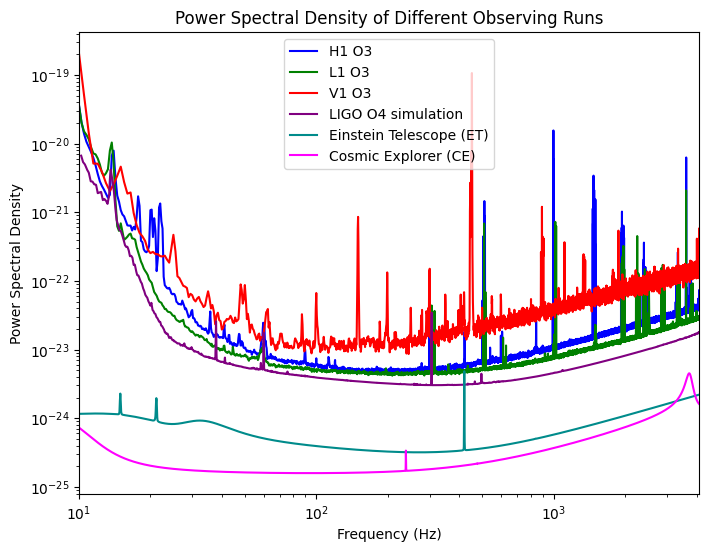

In [ ]:
#read in the PSD data for the different detectors
aligoH1 = pd.read_csv('Sensitivity Curve Data/aligo_O3actual_H1.txt', delim_whitespace=True, header=None, names=["Frequency", "PSD"])
aligoL1 = pd.read_csv('Sensitivity Curve Data/aligo_O3actual_L1.txt', delim_whitespace=True, header=None, names=["Frequency", "PSD"])
avirgo = pd.read_csv('Sensitivity Curve Data/avirgo_O3actual.txt', delim_whitespace=True, header=None, names=["Frequency", "PSD"])
aligo4 = pd.read_csv('Sensitivity Curve Data/aligo_O4high.txt', delim_whitespace=True, header=None, names=["Frequency", "PSD"])

#parameters for psd analytical function for ET and CE
duration = 16  #duration in seconds
delta_f = 1 / duration  #frequency resolution
low_freq_cutoff = 10  #minimum frequency
sampling_rate = 8192  #sampling rate
length = duration*sampling_rate #number of data points (length of PSD array)

#generate PSD for ET and CE using the analytical function
psd_et = analytical.EinsteinTelescopeP1600143(length, delta_f, low_freq_cutoff)
psd_ce = analytical.CosmicExplorerP1600143(length, delta_f, low_freq_cutoff)

#create frequency array for PSD plots as frequency is not provided in the analytical function but delta_f is
freq_et = np.arange(len(psd_et)) * delta_f
freq_ce = np.arange(len(psd_ce)) * delta_f

# Take square root of PSD for plotting, as the LIGO PSD is in units of Hz^1/2 (and judgding by original plots, the analytical function returns 1/Hz instead)
psd_et_sqrt = np.sqrt(psd_et)
psd_ce_sqrt = np.sqrt(psd_ce)

#plot all PSDs on the same plot
plt.figure(figsize=(8,6))
plt.loglog(aligoH1["Frequency"], aligoH1["PSD"], label="H1 O3", color="blue")
plt.loglog(aligoL1["Frequency"], aligoL1["PSD"], label="L1 O3", color="green")
plt.loglog(avirgo["Frequency"], avirgo["PSD"], label="V1 O3", color="red")
plt.loglog(aligo4["Frequency"], aligo4["PSD"], label="LIGO O4 simulation", color="purple")
plt.loglog(freq_et, psd_et_sqrt, label="Einstein Telescope (ET)", color="darkcyan")
plt.loglog(freq_ce, psd_ce_sqrt, label="Cosmic Explorer (CE)", color="magenta")
plt.xlim(low_freq_cutoff, sampling_rate/2) #limits the plot between 10 Hz and the Nyquist frequency
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density of Different Observing Runs")
plt.legend()




The PSD's for the ET and CE simulations seem to be far less susceptible to the low frequency noise that is very apparent in the Ligo curves. This seems to be a significant improvement. Another improvement can be found in the fact that the PSD overall seems to be quite significantly lower than the LIGO PSDs, which suggests a higher sensitivity over all frequencies. This would mean the detectors are more sensitive to weaker gravitational waves. At least according to these simulations, ET and CE should outperform LIGO significantly!